In [6]:
import numpy as np
import pandas as pd
import dill
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (precision_score, f1_score, accuracy_score, \
                             classification_report, \
                             recall_score, confusion_matrix, roc_curve, \
                             precision_recall_curve, ConfusionMatrixDisplay, \
                             RocCurveDisplay,PrecisionRecallDisplay, roc_auc_score)
from sklearn.model_selection import learning_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

TRAIN_PATH = './Data Explorer/train.csv'

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    
    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.arange(0.01, 1, 0.01):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'tresholds':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values[:10, :],
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])                                                                               

    
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))
    
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1, bins=15)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8, bins=15)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

    return np.round(roc_auc_score(y_true_labels, y_predicted_probs), 3), \
            scores_table.values[0, 0], scores_table.values[0, 1], \
            scores_table.values[0, 2], scores_table.values[0, 3]

#--------------------------------------------------------------------------------
# Function to plot a Confusion Matrix
def Plot_Confusion_Matrix(CM,Title="Confusion Matrix"):
    GroupNames       = ["True Neg","False Pos","False Neg","True Pos"]
    GroupCounts      = ["{0:0.0f}".format(x) for x in CM.flatten()]
    GroupPercentages = ["{0:.2%}".format(x) for x in CM.flatten()/np.sum(CM)]
    
    Labels = [f"{x1}\n\n{x2}\n\n{x3}" for x1,x2,x3 in zip(GroupNames,GroupCounts,GroupPercentages)]
    Labels = np.asarray(Labels).reshape(2,2)
    
    FontSize = 12
    plt.figure(figsize=(6,5))
    Ax = sns.heatmap(CM, annot=Labels, fmt="", cmap="Blues")
    Ax.set_title(Title, fontsize=FontSize)
    Ax.set_xlabel("Predicted Values", fontsize=FontSize)
    Ax.set_ylabel("Actual Values", fontsize=FontSize)
    Ax.xaxis.set_ticklabels(["False","True"], fontsize=FontSize)
    Ax.yaxis.set_ticklabels(["False","True"], fontsize=FontSize)
    plt.show()
    return


def evaluate_preds(y_pred, y_test, tresholds):
    probs = y_pred >= tresholds
    print(classification_report(y_test, probs))
    Plot_Confusion_Matrix(confusion_matrix(y_test, probs))
    RocCurveDisplay.from_predictions(y_test, y_pred)
    PrecisionRecallDisplay.from_predictions(y_test, y_pred)
    plt.show()


In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key, column=[]):
        self.key = key
        self.column=column
        self.columns = []

    def fit(self, X, y=None):
        if len(self.column)==0:
            self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        else:
            self.columns = [f'{self.key}_{col}' for col in self.column]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

## 2. Загрузка данных в Data Frame
#### Описание файлов
- train.csv - тренировочные данные
- test.csv - тестовые данные
- gender_submission.csv - образец файла для отправки в правильном формате
#### Описание признаков данных
- survival: выживший -1 или -0
- pclass: Класс билетов 1 = 1st, 2 = 2nd, 3 = 3rd
- sex: Пол
- Age: Возраст в годах
- sibsp: братьев и сестер/супругов на борту "Титаника"
- parch: родителей/детей на борту "Титаника"
- ticket: Номер билета
- fare: Пассажирский тариф
- cabin: Номер каюты
- embarked: Порт отправления C = Шербур, Q = Квинстаун, S = Саутгемптон


In [9]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Рассмотрим поближе каждую характеристику 

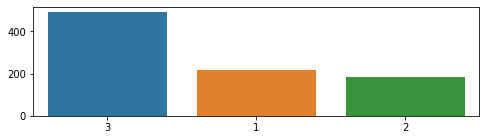


Количество пропущенных элементов 0
3    491
1    216
2    184
Name: Pclass, dtype: int64

Количество уникальных элементов 3


In [11]:
index = 'Pclass'
df_train[index] = df_train[index].astype(str)
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

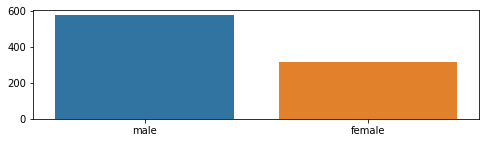


Количество пропущенных элементов 0
male      577
female    314
Name: Sex, dtype: int64

Количество уникальных элементов 2


In [12]:
index = 'Sex'
df_train[index] = df_train[index].astype(str)
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

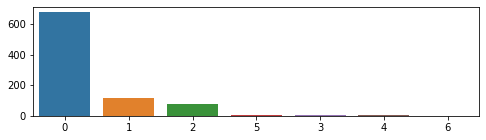


Количество пропущенных элементов 0
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Количество уникальных элементов 7


In [13]:
index = 'Parch'
df_train[index] = df_train[index].astype(str)
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

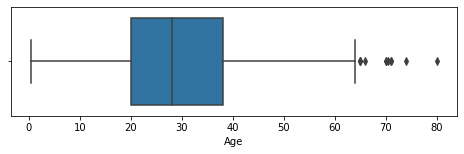


Количество пропущенных элементов 177
Количество уникальных элементов 88
median - 28.000
mean - 29.699
mode - 24.000
квантиль 5% - 4.000
квантиль 98% - 62.740
0.42     1
0.67     1
0.75     2
0.83     2
0.92     1
        ..
70.00    2
70.50    1
71.00    2
74.00    1
80.00    1
Name: Age, Length: 88, dtype: int64


In [14]:
index = 'Age'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
quantile = df_train.loc[df_train[index].notnull(), index]
print(f'Количество уникальных элементов {quantile.value_counts().size}')
print(f'median - {np.quantile(quantile, q=0.5):.3f}\nmean - {np.mean(quantile):.3f}\nmode - {stats.mode(quantile)[0][0]:.3f}')
print(f'квантиль 5% - {np.quantile(quantile, q=0.05):.3f}\nквантиль 98% - {np.quantile(quantile, q=0.98):.3f}')
print(df_train[index].value_counts().sort_index(ascending=True))

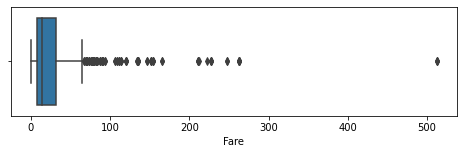


Количество пропущенных элементов 0
Количество уникальных элементов 248
median - 14.454
mean - 32.204
mode - 8.050
квантиль 5% - 7.225
квантиль 98% - 211.338
0.0000      15
4.0125       1
5.0000       1
6.2375       1
6.4375       1
            ..
227.5250     4
247.5208     2
262.3750     2
263.0000     4
512.3292     3
Name: Fare, Length: 248, dtype: int64


In [15]:
index = 'Fare'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
quantile = df_train.loc[df_train[index].notnull(), index]
print(f'Количество уникальных элементов {quantile.value_counts().size}')
print(f'median - {np.quantile(quantile, q=0.5):.3f}\nmean - {np.mean(quantile):.3f}\nmode - {stats.mode(quantile)[0][0]:.3f}')
print(f'квантиль 5% - {np.quantile(quantile, q=0.05):.3f}\nквантиль 98% - {np.quantile(quantile, q=0.98):.3f}')
print(df_train[index].value_counts().sort_index(ascending=True))

In [16]:
index = 'Cabin'
df_train[index] = df_train[index].astype(str)

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')


Количество пропущенных элементов 0
nan            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

Количество уникальных элементов 148


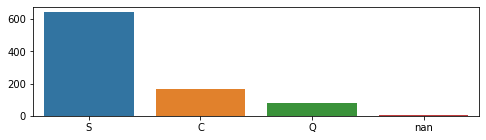


Количество пропущенных элементов 0
S      644
C      168
Q       77
nan      2
Name: Embarked, dtype: int64

Количество уникальных элементов 4


In [17]:
index = 'Embarked'
df_train[index] = df_train[index].astype(str)
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

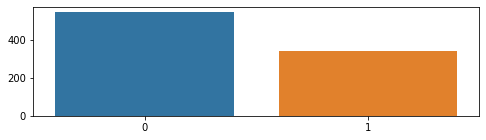


Количество пропущенных элементов 0
0    549
1    342
Name: Survived, dtype: int64

Количество уникальных элементов 2


In [18]:
index = 'Survived'
df_train[index] = df_train[index].astype(str)
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Вывод: имеем не большой дисбаланс классов, в последствии будем проводить балансировку методом Oversampling*

## Обработка данных

In [19]:
df_train = pd.read_csv(TRAIN_PATH, sep=',')

Y = df_train['Survived']
X = df_train.drop(columns=['Survived'])

In [20]:
#features_Drop = ['PassengerId','Name','Ticket', 'Cabin', 'Embarked']
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare']
target = 'Survived'

X = df_train[features]
Y = df_train[target]

### *Разбиение на train и test*

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=Y
                                                    )

# save valid
X_valid.to_csv("./Data Explorer/X_valid.csv", index=None)
y_valid.to_csv("./Data Explorer/y_valid.csv", index=None)

# save train
X_train.to_csv("./Data Explorer/X_train.csv", index=None)
y_train.to_csv("./Data Explorer/y_train.csv", index=None)

Соберем кусок, ответственный за feature engineering

In [22]:
gender = Pipeline([
                    ('selector', ColumnSelector(key='Sex')), 
                    ('ohee', OHEEncoder(key='Sex'))
                  ],
                 verbose=False)

SibSp = Pipeline([
                    ('selector', ColumnSelector(key='SibSp')), 
                    ('ohee', OHEEncoder(key='SibSp', column=['0', '1', '2', '3', '4', '5', '8']))
                  ],
                 verbose=False)

Parch = Pipeline([
                    ('selector', ColumnSelector(key='Parch')), 
                    ('ohee', OHEEncoder(key='Parch', column=['0', '1', '2', '3', '4', '5', '6']))
                  ],
                 verbose=False)

Pclass = Pipeline([
                    ('selector', ColumnSelector(key='Pclass')), 
                    ('ohee', OHEEncoder(key='Pclass'))
                  ],
                 verbose=False)

Age = Pipeline([
                    ('selector', NumberSelector(key='Age')), 
                    ('Imputer', TextImputer(key='Age', value=24))
                ],
                 verbose=False)

Fare = Pipeline([
                    ('selector', NumberSelector(key='Fare'))
                ],
                verbose=False)

feats = FeatureUnion([('gender', gender),
                      ('SibSp', SibSp),
                      ('Parch', Parch),
                      ('Pclass', Pclass),
                      ('Age', Age),
                      ('Fare', Fare)
                      ])

In [23]:
# Балансировка целевой переменной
disbalance = Y.value_counts()[0] / Y.value_counts()[1]
# параметры CatBoost
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

Обучим классификатор

In [24]:
classifier = Pipeline([
                    ('features', feats),
                    ('classifier', CatBoostClassifier(**frozen_params,  
                                                      iterations=300, 
                                                      min_data_in_leaf = 1)),
                    ],
                    verbose=False)

In [25]:
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_valid)

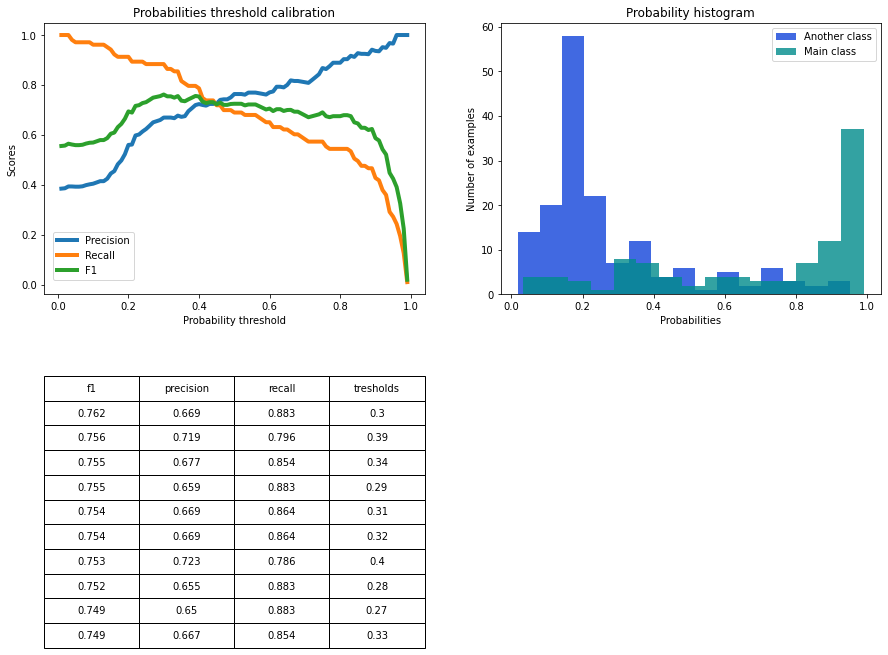

In [26]:
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(y_score[:, 1], y_valid)

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       165
           1       0.67      0.88      0.76       103

    accuracy                           0.79       268
   macro avg       0.79      0.81      0.78       268
weighted avg       0.82      0.79      0.79       268



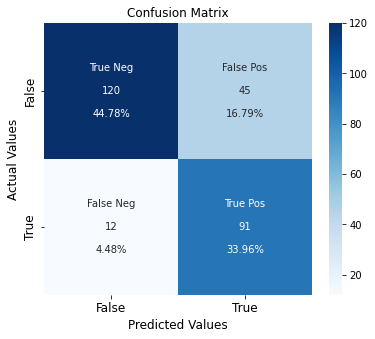

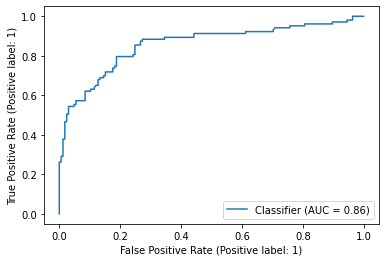

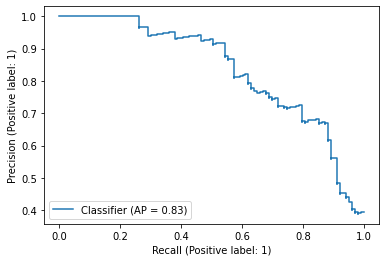

In [27]:
evaluate_preds(y_score[:, 1], y_valid, tresholds)

Сохраним модель (пайплайн)

In [28]:
with open("./app/models/model.dill", "wb") as f:
    dill.dump(classifier, f)